##### Imports

In [1]:
import os
import pandas as pd
import csv

import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

from temp_funcs import path, csv_path, path_jem, \
read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df, create_container_df

from IPython.display import HTML #Display tables

In [2]:
sns.set(context = "notebook", style = "ticks", font="verdana", font_scale = 1.5)
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

In [3]:
fields_morph = ["name", "id", "specimen_id",
                "vrest", "ri", "sag", "tau", "upstroke_downstroke_ratio_long_square", 
                "latency", "f_i_curve_slope"]
path_morph = os.path.join(csv_path, "ephys_mIVSCC_MET.csv")
morph = read_file(path_morph, fields_morph)
morph = drop_nans(morph, ["specimen_id"])
plot_path = os.path.join(path, "plot/short_tall_plot/")

INFO:temp_funcs:Read file in as a pandas dataframe
INFO:temp_funcs:Dropped NaNs from these columns: ['specimen_id']


In [4]:
path_list = os.path.join(csv_path, "short_tall_morph.csv")
morph_list = read_file(path_list)

INFO:temp_funcs:Read file in as a pandas dataframe


In [5]:
morph_list = read_file(path_list)

INFO:temp_funcs:Read file in as a pandas dataframe


In [6]:
morph_list["Morpho type"].unique()

array(['Short', 'Tall'], dtype=object)

In [7]:
morph_list["Projection Class"].unique()

array(['IT', 'CT', nan], dtype=object)

In [8]:
len(morph_list)

188

In [9]:
merged = merge_dataframes(morph, morph_list, "specimen_id", "Cell Specimen Id", "inner")

INFO:temp_funcs:Merged two pandas dataframe into one dataframe


In [10]:
len(merged)

176

##### Function

In [11]:
def create_proportion_table(df, index_col, val_col):
    df["group_count"] = df.groupby([index_col, val_col])[val_col].transform("count")
    df["group_total"] = df.groupby(index_col)[val_col].transform("count")
    df["proportion"] = df["group_count"] / df["group_total"] * 100
    return df

##### Plots

In [12]:
v_colors={"Short": "#ef3b2c", "Tall": "#4292c6"}

##### IT vs CT

In [13]:
p_table1 = create_proportion_table(merged, "Projection Class", "Morpho type")
count_table1 = pd.pivot_table(p_table1, values="group_count", index=["Projection Class"], columns="Morpho type", fill_value=0)
HTML(count_table1.to_html(classes="table table-striped"))

Morpho type,Short,Tall
Projection Class,,
CT,30,72
IT,50,18


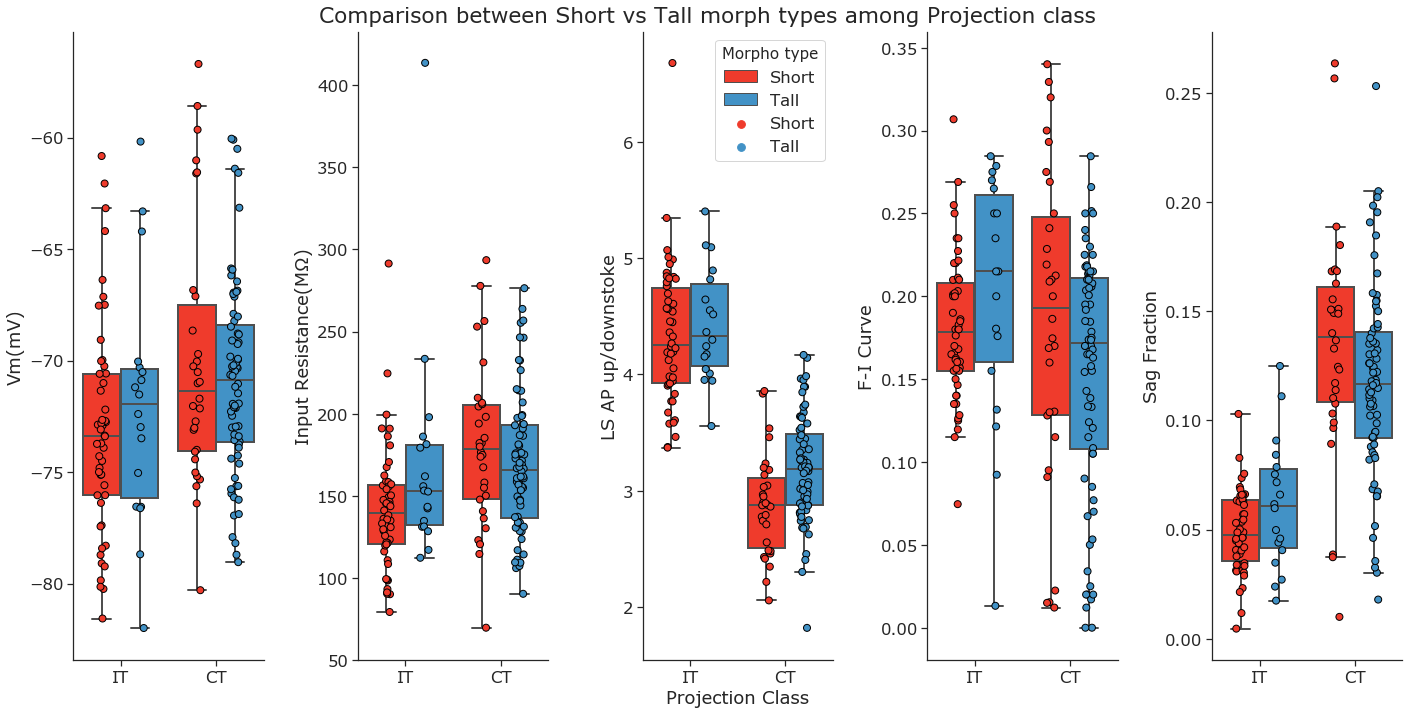

In [14]:
f, axes = plt.subplots(figsize=(20,10), nrows=1, ncols=5, sharex=True)

x="Projection Class"
y0="vrest"
y1="ri"
y2="upstroke_downstroke_ratio_long_square"
y3="f_i_curve_slope"
y4="sag"
hue="Morpho type"


#boxplots
ax0 = sns.boxplot(x=x, y=y0, data=merged, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[0])
ax1 = sns.boxplot(x=x, y=y1, data=merged, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[1])
ax2 = sns.boxplot(x=x, y=y2, data=merged, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[2])
ax3 = sns.boxplot(x=x, y=y3, data=merged, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[3])
ax4 = sns.boxplot(x=x, y=y4, data=merged, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[4])

#stripplots
ax0 = sns.stripplot(x=x, y=y0, data=merged, hue=hue, hue_order=v_colors, 
                    palette=v_colors, dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[0])
ax1 = sns.stripplot(x=x, y=y1, data=merged, hue=hue, hue_order=v_colors,
                    palette=v_colors, dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[1])
ax2 = sns.stripplot(x=x, y=y2, data=merged, hue=hue, hue_order=v_colors,
                    palette=v_colors, dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[2])
ax3 = sns.stripplot(x=x, y=y3, data=merged, hue=hue, hue_order=v_colors,
                    palette=v_colors, dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[3])
ax4 = sns.stripplot(x=x, y=y4, data=merged, hue=hue, hue_order=v_colors,
                    palette=v_colors, dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[4])

#Set x-axis labels
ax0.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Projection Class")
ax3.set_xlabel("")
ax4.set_xlabel("")

#Set y-axis labels
ax0.set_ylabel("Vm(mV)")
ax1.set_ylabel("Input Resistance(MΩ)")
ax2.set_ylabel("LS AP up/downstoke")
ax3.set_ylabel("F-I Curve")
ax4.set_ylabel("Sag Fraction")

#Remove legends
ax0.get_legend().remove()
ax1.get_legend().remove()
#ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

sns.despine(bottom=False, right=True)
f.tight_layout()
plt.suptitle("Comparison between Short vs Tall morph types among Projection class", y=1)
plt.savefig(plot_path + "projection_class.jpeg", bbox_inches="tight")

##### Ttypes Plot

In [15]:
short_ttypes = merged[merged["Morpho type"] == "Short"]
tall_ttypes = merged[merged["Morpho type"] == "Tall"]

In [16]:
def return_subclass_list(df1=short_ttypes, df2=tall_ttypes, num=5):
    """Returns a subclass list with datapoints higher than "specified number
    Parameters:
        new_region_df:
        visp_region_df:
    Returns:
        sub_list:
    """
    
    short_list = list()
    tall_list = list()
    
    for n in df1["VISp Tree Mapping"].unique():
        value = df1[df1["VISp Tree Mapping"] == n]["vrest"].count() >= 5
        if value == True:
            short_list.append(n)
    
    for n in df2["VISp Tree Mapping"].unique():
        value = df2[df2["VISp Tree Mapping"] == n]["vrest"].count() >= 5
        if value == True:
            tall_list.append(n)

    ttype_list = sorted(list(set(short_list) & set(tall_list)))
    return ttype_list

In [17]:
ttype_list = return_subclass_list()
ttype_list

['L6 CT VISp Ctxn3 Brinp3', 'L6 CT VISp Ctxn3 Sla', 'L6 IT VISp Col18a1']

In [18]:
ttypes = merged[merged["VISp Tree Mapping"].isin(ttype_list)]
ttypes.sort_values("VISp Tree Mapping", inplace=True)
len(ttypes)

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


119

In [19]:
p_table2 = create_proportion_table(ttypes, "VISp Tree Mapping", "Morpho type")
count_table2 = pd.pivot_table(p_table2, values="group_count", index=["VISp Tree Mapping"], columns="Morpho type", fill_value=0)
HTML(count_table2.to_html(classes="table table-striped"))

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

Morpho type,Short,Tall
VISp Tree Mapping,,
L6 CT VISp Ctxn3 Brinp3,18,27
L6 CT VISp Ctxn3 Sla,5,28
L6 IT VISp Col18a1,31,10


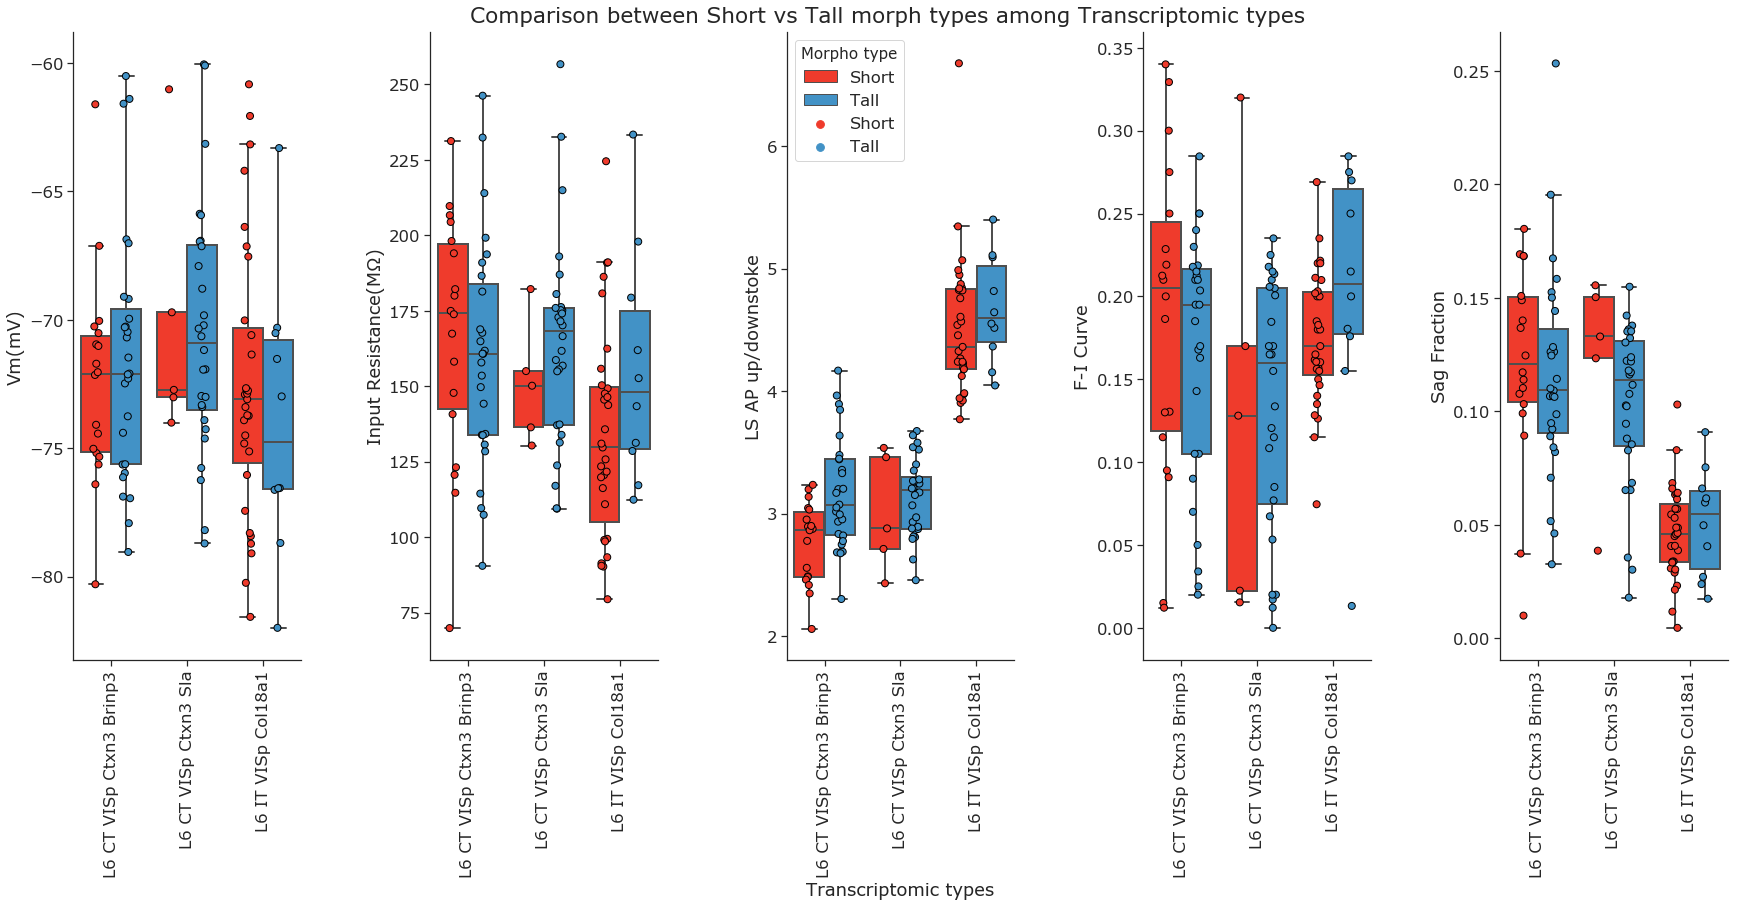

In [20]:
f, axes = plt.subplots(figsize=(25,10), nrows=1, ncols=5, sharex=True)

x="VISp Tree Mapping"
y0="vrest"
y1="ri"
y2="upstroke_downstroke_ratio_long_square"
y3="f_i_curve_slope"
y4="sag"
hue="Morpho type"

#boxplots
ax0 = sns.boxplot(x=x, y=y0, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors, 
                  saturation=1, linewidth=2, showfliers=False, ax=axes[0])
ax1 = sns.boxplot(x=x, y=y1, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[1])
ax2 = sns.boxplot(x=x, y=y2, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[2])
ax3 = sns.boxplot(x=x, y=y3, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[3])
ax4 = sns.boxplot(x=x, y=y4, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors,
                  saturation=1, linewidth=2, showfliers=False, ax=axes[4])

#stripplots
ax0 = sns.stripplot(x=x, y=y0, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors, 
                    dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[0])
ax1 = sns.stripplot(x=x, y=y1, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors, 
                    dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[1])
ax2 = sns.stripplot(x=x, y=y2, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors, 
                    dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[2])
ax3 = sns.stripplot(x=x, y=y3, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors, 
                    dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[3])
ax4 = sns.stripplot(x=x, y=y4, data=ttypes, hue=hue, hue_order=v_colors, palette=v_colors, 
                    dodge=True, size=7, edgecolor="black", linewidth=1, ax=axes[4])

#Set x-axis labels
ax0.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("Transcriptomic types")
ax3.set_xlabel("")
ax4.set_xlabel("")

#Set y-axis labels
ax0.set_ylabel("Vm(mV)")
ax1.set_ylabel("Input Resistance(MΩ)")
ax2.set_ylabel("LS AP up/downstoke")
ax3.set_ylabel("F-I Curve")
ax4.set_ylabel("Sag Fraction")

#Remove legends
ax0.get_legend().remove()
ax1.get_legend().remove()
#ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()


sns.despine(bottom=False, right=True)
f.tight_layout()
plt.suptitle("Comparison between Short vs Tall morph types among Transcriptomic types", y=1)
for ax in f.axes:
    ax.tick_params(axis="x", labelrotation=90)
plt.savefig(plot_path + "ttypes.jpeg", bbox_inches="tight")